# 06. Model selection

### 1. Implement a linear model

* return the weight parameters w = (w1, w2, ... , wP) and the intercept parameter w0 separately where:


$$ \hat{y}(\vec{w}, \vec{x}) = w_0 + w_1 x_1 + ... + w_p x_p$$


* check your returned coefficients with the built in `LinearRegression` class from the `sklearn` library, they should be within tolerance `1e-6`to each other


* use a generated regression dataset `from sklearn.dataset import make_regression` API with parameters `n_samples=1000` and `n_features=20`

### 2. Use of real data

* download the [Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) from UCI, the task includes understanding the dataset: naming the appropiate data fields, handling missing values, etc.
    
* fit a `LinearRegression` model with 5-fold cross-validation - compare training and testing scores (R^2 by default) for the different CV splits, print the mean score and its standard deviation

* find the best `Lasso` regression model with 5-fold grid search cross validation (`GridSearchCV`) on the parameters: `alpha, normalize, max_iter` and show the best parameter set


### 3. Shrinkage

* interpret Lasso model's findings based on its descriptive parameters by the shrinkage method described during the lecture (make a plot and check the names of the features that are not eliminated by the penalty parameter) on the data we have here (this is an explanatory data analysis problem, be to be creative)

* fit Ridge model and apply the shrinkage method as well, did you get what you expect?

* do you think normalization is needed here? If so, do not forget!

### 4. Subset selection

* Split the data to a training and test set and do recursive feature elimination until 10 remaining predictors with 5-fold cross-validated regressors (`RidgeCV`, `LassoCV`, `ElasticNetCV`) on the training set, plot their names and look up some of their meanings (recursive feature elimination is part of `sklearn` but you can do it with a for loop if you whish).

* Do all models provide the same descriptors? Check their performance on the test set! Plot all model predictions compared to the `y_test` on 3 different plots, which model seems to be the best?

### 5. ElasticNet penalty surface

* visualize the surface of the $ objective(\alpha, \beta) $ parameters corresponding to the L1 and L2 regularizations. Select the best possible combination of the hyper-parameters that minimize the objective (clue: `from scipy.optimize import minimize`)
    * this task is similar to what you've seen during class, just not for MSE vs. single penalty parameter but MSE vs. two penalty parameters $\alpha, \beta$

* interpret the findings! do you think linear models are powerful enough on this dataset?

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def missing_value_summary(df,df_title="",tpose = True,figsize=[15,6]):
    '''
    tpose - True if the figure should be transposed
    '''
    num_of_na = df.isna().sum(axis=0) #Dict with number of missing features by column
    print("Missing values in {}\n".format(df_title))
    [print(x,":",num_of_na[x]) 
     if num_of_na[x] != 0 
     else None 
     for x in df.columns] # Broken into multiple lines for better readability

    print("\nratio of missing features in the whole table: ", df.isna().sum().sum()/df.count().sum() )
    print("Number of rows: ", df.shape[0])
    
    plt.figure(figsize=figsize)
    if tpose:
        plt.imshow(df.isna().T)
        
    else:
        plt.imshow(df.isna())

# 1. Implement a linear model

* return the weight parameters w = (w1, w2, ... , wP) and the intercept parameter w0 separately where:


$$ \hat{y}(\vec{w}, \vec{x}) = w_0 + w_1 x_1 + ... + w_p x_p$$


* check your returned coefficients with the built in `LinearRegression` class from the `sklearn` library, they should be within tolerance `1e-6`to each other


* use a generated regression dataset `from sklearn.dataset import make_regression` API with parameters `n_samples=1000` and `n_features=20`

In [3]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
x_toy, y_toy, coef_toy = make_regression(n_samples = 1000, n_features = 20, coef = True)

In [4]:
class myLinReg:
    
    def __add_intercept(self, X):
        intercept = np.ones((x_toy.shape[0], 1))
        return np.concatenate((x_toy, intercept), axis=1)
    
    def fit(self,X,Y):
        X = self.__add_intercept(x_toy)
        coefs = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),Y)
        self.coef = coefs[:-1]
        self.intercept = coefs[-1]

In [5]:
mlg = myLinReg()
mlg.fit(x_toy,y_toy)

sk_linreg = LinearRegression()
sk_linreg.fit(x_toy,y_toy)

print("Matching coefficients:\n",(abs(sk_linreg.coef_ - mlg.coef) < 10**(-6)).all())
print("Matching intercept:\n",abs(mlg.intercept - sk_linreg.intercept_) < 10**(-6))

Matching coefficients:
 True
Matching intercept:
 True


# 2. Use of real data

* download the [Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) from UCI, the task includes understanding the dataset: naming the appropiate data fields, handling missing values, etc.
    
* fit a `LinearRegression` model with 5-fold cross-validation - compare training and testing scores (R^2 by default) for the different CV splits, print the mean score and its standard deviation

* find the best `Lasso` regression model with 5-fold grid search cross validation (`GridSearchCV`) on the parameters: `alpha, normalize, max_iter` and show the best parameter set

## Data preprocessing

In [6]:
#Loading names 
f = open("communities.names")
lines = f.readlines() #short text, most convenient
f.close()
names = lines[75:203]
names1 = [x.replace("@attribute ","").replace(" numeric\n","").replace(" string\n","") for x in names] 

names1[:10],len(names)

(['state',
  'county',
  'community',
  'communityname',
  'fold',
  'population',
  'householdsize',
  'racepctblack',
  'racePctWhite',
  'racePctAsian'],
 128)

In [7]:
crime_data = pd.read_csv("communities.data",header = None, names = names1, na_values = "?")

crime_data[crime_data.columns[5:]].max().max(),crime_data[crime_data.columns[5:]].min().min()
#Thank God it's normalized.

(1.0, 0.0)

Missing values in Crime data

county : 1174
community : 1177
OtherPerCap : 1
LemasSwornFT : 1675
LemasSwFTPerPop : 1675
LemasSwFTFieldOps : 1675
LemasSwFTFieldPerPop : 1675
LemasTotalReq : 1675
LemasTotReqPerPop : 1675
PolicReqPerOffic : 1675
PolicPerPop : 1675
RacialMatchCommPol : 1675
PctPolicWhite : 1675
PctPolicBlack : 1675
PctPolicHisp : 1675
PctPolicAsian : 1675
PctPolicMinor : 1675
OfficAssgnDrugUnits : 1675
NumKindsDrugsSeiz : 1675
PolicAveOTWorked : 1675
PolicCars : 1675
PolicOperBudg : 1675
LemasPctPolicOnPatr : 1675
LemasGangUnitDeploy : 1675
PolicBudgPerPop : 1675

ratio of missing features in the whole table:  0.18146553719390826
Number of rows:  1994


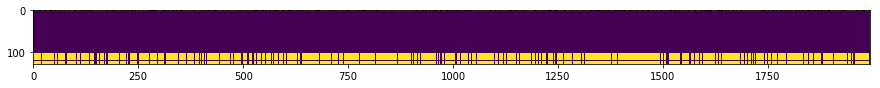

In [8]:
missing_value_summary(crime_data,tpose = True,df_title="Crime data")

This way, it is clear, that in a couple of columns between 101 and 126 most of the data is missing.
We can see, that there is a systematical absence of values, meaning the rows with missing values in the same columns might have something in common. So I suspect it may be a good idea to try to figure out what can be the reason of this separation.

In [9]:
print(crime_data.population[ crime_data.LemasSwornFT.notna() ].describe())
print(crime_data.population[ crime_data.LemasSwornFT.isna() ].describe())

count    319.000000
mean       0.229342
std        0.243098
min        0.000000
25%        0.080000
50%        0.140000
75%        0.255000
max        1.000000
Name: population, dtype: float64
count    1675.000000
mean        0.024884
std         0.035443
min         0.000000
25%         0.010000
50%         0.020000
75%         0.030000
max         0.700000
Name: population, dtype: float64


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.01, 1)

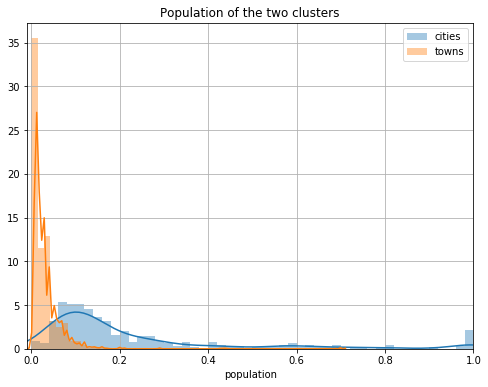

In [10]:
plt.figure(figsize=[8,6])
sns.distplot(crime_data.population[ crime_data.LemasSwornFT.notna() ],bins = 50,label="cities")
sns.distplot(crime_data.population[ crime_data.LemasSwornFT.isna() ],bins = 50,label="towns")
plt.title("Population of the two clusters")
plt.legend()
plt.grid()
plt.xlim(-0.01,1)

On the graph and the statistical description above, we can see, that the two sets with grouped missing features are two distinct groups: one with larger population, and another with substantially smaller population. So that the idea of separation of these two sets of the data seems reasonable.

In [11]:
cities = crime_data[crime_data.LemasSwornFT.notna()]
towns = crime_data[crime_data.LemasSwornFT.isna()]

Missing values in 

county : 193
community : 196

ratio of missing features in the whole table:  0.009618475385109907
Number of rows:  319


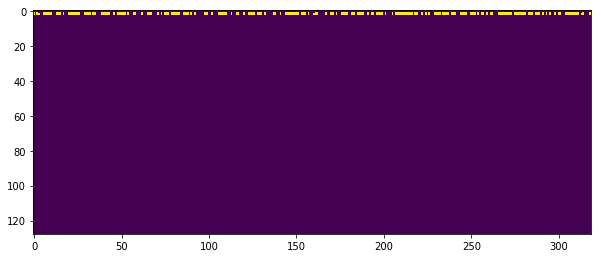

In [12]:
missing_value_summary(cities,figsize=[10,8])

Missing values in 

county : 981
community : 981
OtherPerCap : 1
LemasSwornFT : 1675
LemasSwFTPerPop : 1675
LemasSwFTFieldOps : 1675
LemasSwFTFieldPerPop : 1675
LemasTotalReq : 1675
LemasTotReqPerPop : 1675
PolicReqPerOffic : 1675
PolicPerPop : 1675
RacialMatchCommPol : 1675
PctPolicWhite : 1675
PctPolicBlack : 1675
PctPolicHisp : 1675
PctPolicAsian : 1675
PctPolicMinor : 1675
OfficAssgnDrugUnits : 1675
NumKindsDrugsSeiz : 1675
PolicAveOTWorked : 1675
PolicCars : 1675
PolicOperBudg : 1675
LemasPctPolicOnPatr : 1675
LemasGangUnitDeploy : 1675
PolicBudgPerPop : 1675

ratio of missing features in the whole table:  0.2210471162443689
Number of rows:  1675


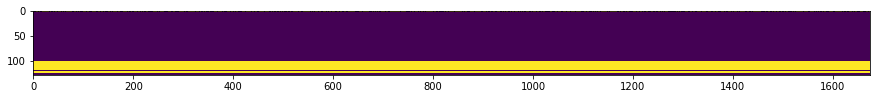

In [13]:
#get rid of the county and community column
cities = cities.drop(columns = ["county","community","communityname"])
missing_value_summary(towns)

In [14]:
#we should also remove the columns with missing values from the towns df
towns = towns.drop(columns = ["county","community","communityname","LemasSwornFT","LemasSwFTPerPop",
                            "LemasSwFTFieldOps","LemasSwFTFieldPerPop","LemasTotalReq" ,
                            "LemasTotReqPerPop","PolicReqPerOffic" ,"PolicPerPop" ,
                            "RacialMatchCommPol","PctPolicWhite","PctPolicBlack","PctPolicHisp",
                            "PctPolicAsian","PctPolicMinor","OfficAssgnDrugUnits",
                            "NumKindsDrugsSeiz" ,"PolicAveOTWorked","PolicCars","PolicOperBudg",
                            "LemasPctPolicOnPatr","LemasGangUnitDeploy","PolicBudgPerPop"])
#and impute the rest with the mean

towns = towns.fillna(towns.mean())

In [15]:
x_town = towns[towns.columns[:-1]] 
y_town = towns[towns.columns[-1]]
x_city = cities[cities.columns[:-1]]
y_city = cities[cities.columns[-1]]

## Linear regression with CV

In [16]:
from sklearn.model_selection import cross_validate
linreg2 = LinearRegression()
scores2_lr_town = cross_validate(linreg2, x_town, y_town, cv=5,scoring=('r2'), return_train_score=True)
scores2_lr_city = cross_validate(linreg2, x_city, y_city, cv=5,scoring=('r2'), return_train_score=True)

towns
Train score: std=0.01741, mean=0.64053
Test score:  std=0.07881, mean=0.55461

cities
Train score: std=0.00574, mean=0.84464
Test score:  std=0.07755, mean=0.39172


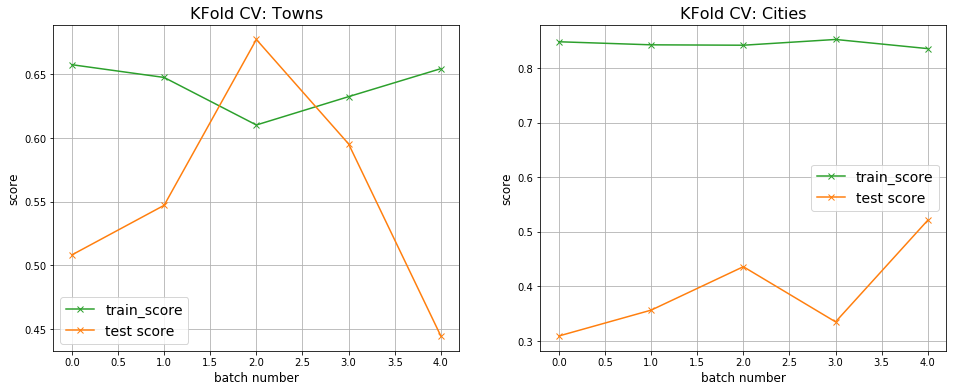

In [17]:
plt.figure(figsize=[16,6])
plt.subplot(121)
plt.title("KFold CV: Towns",size=16)
plt.plot(np.arange(5),scores2_lr_town["train_score"],label="train_score",marker="x",color="tab:green")
plt.plot(np.arange(5),scores2_lr_town["test_score"],label="test score",marker="x",color="tab:orange")
plt.xlabel("batch number",size=12)
plt.ylabel("score",size=12)
plt.legend(fontsize=14)
plt.grid()
print("towns")
print("Train score: std={}, mean={}".format(round(scores2_lr_town["train_score"].std() ,5),
                                            round(scores2_lr_town["train_score"].mean(),5)))
print("Test score:  std={}, mean={}\n".format(round(scores2_lr_town["test_score"].std() ,5),
                                            round(scores2_lr_town["test_score"].mean(),5)))

plt.subplot(122)
plt.title("KFold CV: Cities",size=16)
plt.plot(np.arange(5),scores2_lr_city["train_score"],label="train_score",marker="x",color="tab:green")
plt.plot(np.arange(5),scores2_lr_city["test_score"],label="test score",marker="x",color="tab:orange")
plt.xlabel("batch number",size=12)
plt.ylabel("score",size=12)
plt.legend(fontsize=14)
plt.grid()
print("cities")
print("Train score: std={}, mean={}".format(round(scores2_lr_city["train_score"].std() ,5),
                                            round(scores2_lr_city["train_score"].mean(),5)))
print("Test score:  std={}, mean={}".format(round(scores2_lr_city["test_score"].std() ,5),
                                            round(scores2_lr_city["test_score"].mean(),5)))

On these graphs we can see that the test score is lower in most cases, while the fluctuation in these sets is much higher.

## Hyperparameter tuning for Lasso regression

In [18]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

parameters = {"alpha": np.linspace(0.03,1,20), "normalize": (True,False) , "max_iter": (5, 50, 100, 500, 1000, 10000)}
lasso1 = Lasso()
lasso2 = Lasso()
clf = GridSearchCV(lasso1, parameters, cv=5)
clf.fit(x_town,y_town)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.03      , 0.08105263, 0.13210526, 0.18315789, 0.23421053,
       0.28526316, 0.33631579, 0.38736842, 0.43842105, 0.48947368,
       0.54052632, 0.59157895, 0.64263158, 0.69368421, 0.74473684,
       0.79578947, 0.84684211, 0.89789474, 0.94894737, 1.        ]),
                         'max_iter': (5, 50, 100, 500, 1000, 10000),
                         'normalize': (True, False)})

In [19]:
print("Best hyperparameters for the town dataset:")
clf.best_params_

Best hyperparameters for the town dataset:


{'alpha': 0.03, 'max_iter': 5, 'normalize': False}

In [20]:
clf2 = GridSearchCV(lasso2,parameters,cv=5).fit(x_city,y_city)
print("Best hyperparameters for the city dataset:")
clf2.best_params_
#Warnings occur when using small alpha and max_iter because of convergence issues

/home/dvtulf/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05792777406744598, tolerance: 0.002032419843137255
  positive)
/home/dvtulf/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03439150030418858, tolerance: 0.001908689254901961
  positive)
/home/dvtulf/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02896149661325964, tolerance: 0.0018662946666666666
  positive)
/home/dvtulf/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase

Best hyperparameters for the city dataset:


/home/dvtulf/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052096950282876975, tolerance: 0.002428554733542319
  positive)


{'alpha': 0.03, 'max_iter': 5, 'normalize': False}

(0, 0.9)

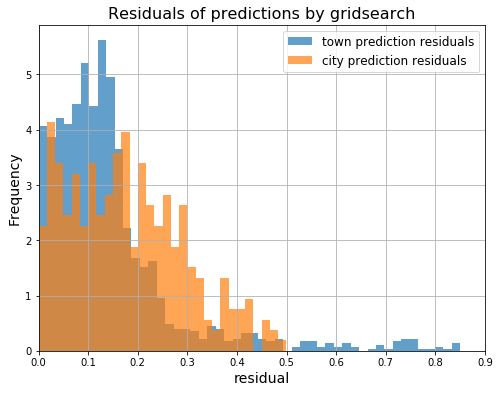

In [25]:
plt.figure(figsize=[8,6])
plt.title("Residuals of predictions by gridsearch",size=16)
plt.hist(np.abs(clf.predict(x_town) - y_town),bins=50,alpha=0.7,density=True,label="town prediction residuals")
plt.hist(np.abs(clf2.predict(x_city) - y_city),bins=30,alpha=0.7,density=True,label="city prediction residuals")
plt.xlabel("residual",size=14)
plt.ylabel("Frequency",size=14)
plt.grid()
plt.legend(fontsize=12)
plt.xlim(0,0.9)

# 3. Shrinkage

* interpret Lasso model's findings based on its descriptive parameters by the shrinkage method described during the lecture (make a plot and check the names of the features that are not eliminated by the penalty parameter) on the data we have here (this is an explanatory data analysis problem, be to be creative)

* fit Ridge model and apply the shrinkage method as well, did you get what you expect?

* do you think normalization is needed here? If so, do not forget!

Text(0.5, 1.0, 'L1 Factor shrinkage: towns')

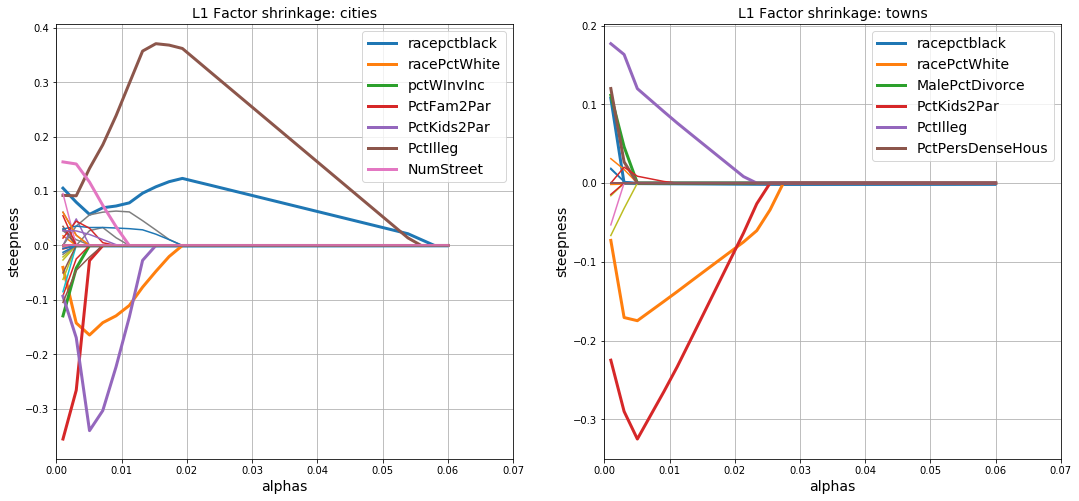

In [26]:
from matplotlib.colors import TABLEAU_COLORS
alphas = np.linspace(0.001,0.06,30)
coef_city = []
coef_town = []

for a in alphas:
    lasso3 = Lasso(alpha = a)
    lasso3.fit(x_city,y_city)
    coef_city.append(lasso3.coef_)
    lasso3.fit(x_town,y_town)
    coef_town.append(lasso3.coef_)
    
plt.figure(figsize=[18,8])
plt.subplot(121)
cnt = 0
for i in range(len(x_city.columns)):
    
    if (np.abs(np.array(coef_city)[:,i])>0.11).any(): #add label if the feature is relevant
        plt.plot(alphas, np.array(coef_city)[:,i],label=x_city.columns[i],lw=3, 
                 color=list(TABLEAU_COLORS.keys())[cnt])
        cnt += 1
    else:
        plt.plot(alphas, np.array(coef_city)[:,i])
plt.xlabel("alphas",size=14)
plt.ylabel("steepness",size=14)
plt.grid()
plt.legend(fontsize=14)
plt.xlim(0,0.07)
plt.title("L1 Factor shrinkage: cities",size=14)

plt.subplot(122)

cnt = 0
for i in range(len(x_town.columns)):
    
    if (np.abs(np.array(coef_town)[:,i])>0.1).any(): #add label if the feature is relevant
        plt.plot(alphas, np.array(coef_town)[:,i],label=x_town.columns[i],lw=3, 
                 color=list(TABLEAU_COLORS.keys())[cnt])
        cnt += 1
    else:
        plt.plot(alphas, np.array(coef_town)[:,i])
plt.xlabel("alphas",size=14)
plt.ylabel("steepness",size=14)
plt.grid()
plt.legend(fontsize=14)
plt.xlim(0,0.07)

plt.title("L1 Factor shrinkage: towns",size=14)

Text(0.5, 1.0, 'L2 Factor shrinkage: towns')

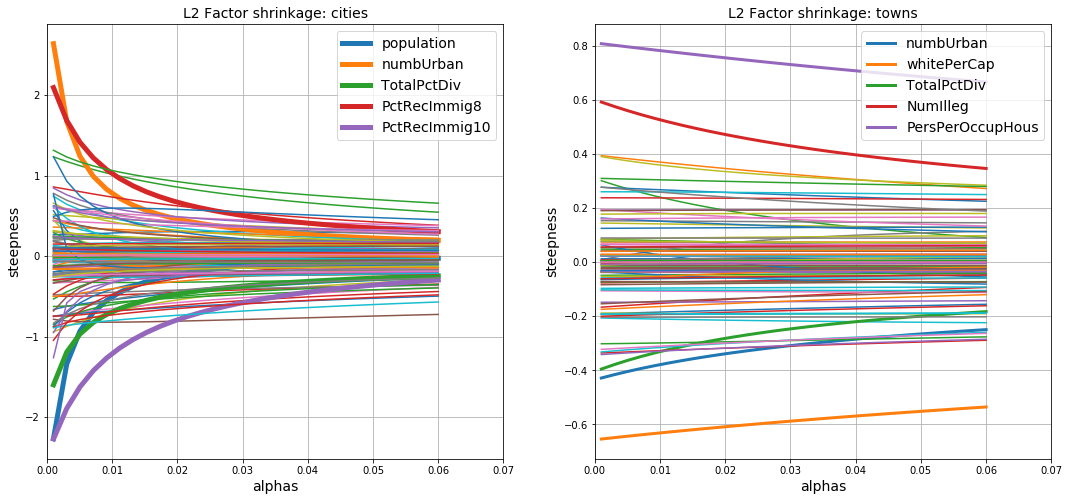

In [27]:
from sklearn.linear_model import Ridge
alphas = np.linspace(0.001,0.06,30)
coef_city = []
coef_town = []

for a in alphas:
    ridge3 = Ridge(alpha = a)
    ridge3.fit(x_city,y_city)
    coef_city.append(ridge3.coef_)
    ridge3.fit(x_town,y_town)
    coef_town.append(ridge3.coef_)
    
plt.figure(figsize=[18,8])
plt.subplot(121)
cnt = 0
for i in range(len(x_city.columns)):
    
    if (np.abs(np.array(coef_city)[:,i])>1.4).any(): #add label if the feature is relevant
        plt.plot(alphas, np.array(coef_city)[:,i],label=x_city.columns[i],lw=5, 
                 color=list(TABLEAU_COLORS.keys())[cnt])
        cnt += 1
    else:
        plt.plot(alphas, np.array(coef_city)[:,i])

plt.grid()
plt.xlabel("alphas",size=14)
plt.ylabel("steepness",size=14)
plt.legend(fontsize=14)
plt.xlim(0,0.07)
plt.title("L2 Factor shrinkage: cities",size=14)

plt.subplot(122)

cnt = 0
for i in range(len(x_town.columns)):
    
    if (np.abs(np.array(coef_town)[:,i])>0.395).any(): #add label if the feature is relevant
        plt.plot(alphas, np.array(coef_town)[:,i],label=x_town.columns[i],lw=3, 
                 color=list(TABLEAU_COLORS.keys())[cnt])
        cnt += 1
    else:
        plt.plot(alphas, np.array(coef_town)[:,i])

plt.grid()
plt.legend(fontsize=14)
plt.xlim(0,0.07)
plt.xlabel("alphas",size=14)
plt.ylabel("steepness",size=14)

plt.title("L2 Factor shrinkage: towns",size=14)

In [29]:
crime_data[crime_data.columns[5:]].max().max(),crime_data[crime_data.columns[5:]].min().min()
#Thank God it was normalized.

(1.0, 0.0)

Normalization is not needed since the data is normalized already.

I've fit multiple Lasso and Ridge models with various alphas to find the features with the steepest slopes.
My findings with the most important features are listed in the following table. Next to the features there is a (+)/(-), which means if the steepness is positive or negative, thus contributing positively or negatively to the violent crime per population ratio.

| L1 cities        | L1 towns            | L2 cities        | L2 towns         |
|------------------|---------------------|------------------|------------------|
| racepctblack (+) | racepctblack (+)    | population (+)   | numbUrban (-)    |
| racepctwhite (-) | racepctwhite (-)    | numbUrban(+)     | whiteperCap(-)   |
| pctwinvinc (-)   | malepctDivorce (+)  | totalPctDiv(-)   | totalPctDiv(-)   |
| pctFam2Par (-)   | pctkids2Par (-)     | pctrecimmig8(+)  | NumIlleg (+)     |
| pctKids2Par (-)  | pctIlleg (+)        | pctrecimmig10(-) | PersOccupHous(+) |
| pctIlleg (+)     | pctPersDenseHous(+) |       
| numStreet (+)    |                   

We can see from the table above, that there are several features which can be found important across the measures.
Racial background certainly seems to be an issue here. Other than that, familial status of the inhabitants is the key here: the more stable the family background (parents not divorced), the less violent crimes committed.
<br> There's also another notion, which I've found quite interesting, that immigrants, who have immigrated in the last 8 years contribute towards higher crime rate, but those who have immigrated in 10 years, are reducing crime risks. We could conclude, that the decision boundary in immigrant background must be between 8 and 10 years. It might be the case because settling and establishing a new existence takes a longer time. Or another option is that those, who have immigrated more recently tend to be originated from a more violent culture or country.

# 4. Subset selection

* Split the data to a training and test set and do recursive feature elimination until 10 remaining predictors with 5-fold cross-validated regressors (`RidgeCV`, `LassoCV`, `ElasticNetCV`) on the training set, plot their names and look up some of their meanings (recursive feature elimination is part of `sklearn` but you can do it with a for loop if you whish).

* Do all models provide the same descriptors? Check their performance on the test set! Plot all model predictions compared to the `y_test` on 3 different plots, which model seems to be the best?

In [100]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

x_city_train, x_city_test, y_city_train, y_city_test = train_test_split(x_city, y_city, test_size=0.33)
x_town_train, x_town_test, y_town_train, y_town_test = train_test_split(x_town, y_town, test_size=0.33)


RCV = RidgeCV(alphas = np.linspace(0.03,1,20),cv = 5)
LCV = LassoCV(alphas = np.linspace(0.03,1,20),cv = 5)
ENCV = ElasticNetCV(alphas = np.linspace(0.03,1,20),cv = 5,l1_ratio = np.linspace(0.1,0.9,20))

In [101]:
rfe_rcv = RFE(RCV, n_features_to_select = 10)
rfe_rcv.fit(x_town_train,y_town_train)

rfe_lcv = RFE(LCV, n_features_to_select = 10)
rfe_lcv.fit(x_town_train,y_town_train)

rfe_encv = RFE(ENCV, n_features_to_select = 10)
rfe_encv.fit(x_town_train,y_town_train)

RFE(estimator=ElasticNetCV(alphas=array([0.03      , 0.08105263, 0.13210526, 0.18315789, 0.23421053,
       0.28526316, 0.33631579, 0.38736842, 0.43842105, 0.48947368,
       0.54052632, 0.59157895, 0.64263158, 0.69368421, 0.74473684,
       0.79578947, 0.84684211, 0.89789474, 0.94894737, 1.        ]),
                           cv=5,
                           l1_ratio=array([0.1       , 0.14210526, 0.18421053, 0.22631579, 0.26842105,
       0.31052632, 0.35263158, 0.39473684, 0.43684211, 0.47894737,
       0.52105263, 0.56315789, 0.60526316, 0.64736842, 0.68947368,
       0.73157895, 0.77368421, 0.81578947, 0.85789474, 0.9       ])),
    n_features_to_select=10)

In [102]:
[print(x) for x in x_town_train.columns[rfe_rcv.support_]]
print("\n")
[print(x) for x in x_town_train.columns[rfe_lcv.support_]]
print("\n")
[print(x) for x in x_town_train.columns[rfe_encv.support_]]

racepctblack
medFamInc
MalePctDivorce
PctKids2Par
PctIlleg
PersPerOccupHous
PersPerOwnOccHous
PctPersDenseHous
HousVacant
NumInShelters


state
racePctHisp
PctBornSameState
PctSameHouse85
PctSameCity85
PctSameState85
LandArea
PopDens
PctUsePubTrans
LemasPctOfficDrugUn


racepctblack
racePctWhite
pctWPubAsst
MalePctDivorce
TotalPctDiv
PctFam2Par
PctKids2Par
PctYoungKids2Par
PctIlleg
PctPersDenseHous


[None, None, None, None, None, None, None, None, None, None]

In [103]:
rfe_rcv = RFE(RCV, n_features_to_select = 10)
rfe_rcv.fit(x_city_train,y_city_train)

rfe_lcv = RFE(LCV, n_features_to_select = 10)
rfe_lcv.fit(x_city_train,y_city_train)

rfe_encv = RFE(ENCV, n_features_to_select = 10)
rfe_encv.fit(x_city_train,y_city_train)

RFE(estimator=ElasticNetCV(alphas=array([0.03      , 0.08105263, 0.13210526, 0.18315789, 0.23421053,
       0.28526316, 0.33631579, 0.38736842, 0.43842105, 0.48947368,
       0.54052632, 0.59157895, 0.64263158, 0.69368421, 0.74473684,
       0.79578947, 0.84684211, 0.89789474, 0.94894737, 1.        ]),
                           cv=5,
                           l1_ratio=array([0.1       , 0.14210526, 0.18421053, 0.22631579, 0.26842105,
       0.31052632, 0.35263158, 0.39473684, 0.43684211, 0.47894737,
       0.52105263, 0.56315789, 0.60526316, 0.64736842, 0.68947368,
       0.73157895, 0.77368421, 0.81578947, 0.85789474, 0.9       ])),
    n_features_to_select=10)

In [104]:
[print(x) for x in x_city_train.columns[rfe_rcv.support_]]
print("\n")
[print(x) for x in x_city_train.columns[rfe_lcv.support_]]
print("\n")
[print(x) for x in x_city_train.columns[rfe_encv.support_]]

pctWInvInc
NumUnderPov
PctLess9thGrade
PctFam2Par
PctKids2Par
PctIlleg
HousVacant
RentLowQ
NumStreet
PctForeignBorn


state
racepctblack
PctIlleg
PctHousLess3BR
MedNumBR
HousVacant
PctHousOccup
PctHousOwnOcc
PctVacantBoarded
PctVacMore6Mos


racepctblack
racePctWhite
racePctHisp
MalePctDivorce
PctFam2Par
PctKids2Par
PctYoungKids2Par
PctTeen2Par
PctIlleg
NumStreet


[None, None, None, None, None, None, None, None, None, None]

| Towns: RCV feature elim | Towns: LCV feature elim | Towns: ENCV feature elim | Cities: RCV feature elim | Cities: LCV feature elim | Cities: ENCV feature elim |
|-------------------------|-------------------------|--------------------------|--------------------------|--------------------------|---------------------------|
| racepctblack            | state                   | racepctblack             | pctWInvInc               | state                    | racepctblack              |
| agePct12t29             | racePctHisp             | racePctWhite             | OtherPerCap              | racepctblack             | racePctWhite              |
| PctKids2Par             | PctBornSameState        | pctWPubAsst              | PctLess9thGrade          | PctIlleg                 | racePctHisp               |
| PctIlleg                | PctSameHouse85          | MalePctDivorce           | PctFam2Par               | PctHousLess3BR           | MalePctDivorce            |
| PctNotSpeakEnglWell     | PctSameCity85           | TotalPctDiv              | PctKids2Par              | MedNumBR                 | PctFam2Par                |
| PctPersDenseHous        | PctSameState85          | PctFam2Par               | PctIlleg                 | HousVacant               | PctKids2Par               |
| HousVacant              | LandArea                | PctKids2Par              | PctPersDenseHous         | PctHousOccup             | PctYoungKids2Par          |
| NumInShelters           | PopDens                 | PctYoungKids2Par         | PctHousOccup             | PctHousOwnOcc            | PctTeen2Par               |
| NumStreet               | PctUsePubTrans          | PctIlleg                 | MedOwnCostPctInc         | PctVacantBoarded         | PctIlleg                  |
| PctForeignBorn          | LemasPctOfficDrugUn     | PctPersDenseHous         | NumStreet                | PctVacMore6Mos           | NumStreet                 |

In [105]:
rfe_rcv = RFE(RCV, n_features_to_select = 10)
rfe_rcv.fit(x_town_train,y_town_train)

rfe_lcv = RFE(LCV, n_features_to_select = 10)
rfe_lcv.fit(x_town_train,y_town_train)

rfe_encv = RFE(ENCV, n_features_to_select = 10)
rfe_encv.fit(x_town_train,y_town_train)

RFE(estimator=ElasticNetCV(alphas=array([0.03      , 0.08105263, 0.13210526, 0.18315789, 0.23421053,
       0.28526316, 0.33631579, 0.38736842, 0.43842105, 0.48947368,
       0.54052632, 0.59157895, 0.64263158, 0.69368421, 0.74473684,
       0.79578947, 0.84684211, 0.89789474, 0.94894737, 1.        ]),
                           cv=5,
                           l1_ratio=array([0.1       , 0.14210526, 0.18421053, 0.22631579, 0.26842105,
       0.31052632, 0.35263158, 0.39473684, 0.43684211, 0.47894737,
       0.52105263, 0.56315789, 0.60526316, 0.64736842, 0.68947368,
       0.73157895, 0.77368421, 0.81578947, 0.85789474, 0.9       ])),
    n_features_to_select=10)

Text(0, 0.5, 'residuals')

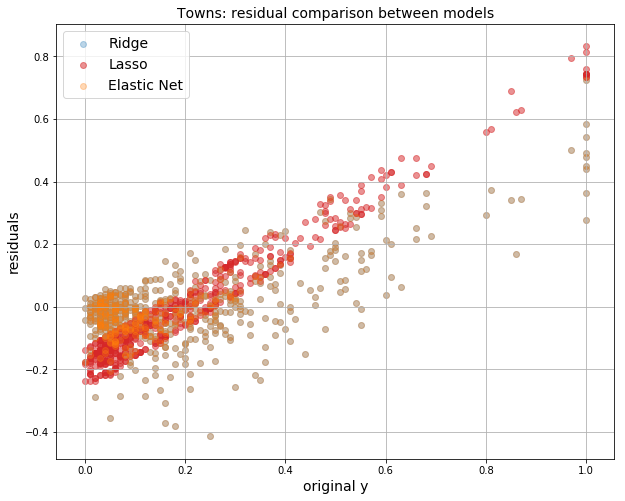

In [106]:
plt.figure(figsize=[10,8])
plt.title("Towns: residual comparison between models",size=14)
plt.scatter(y_town_test, y_town_test - rfe_rcv.predict(x_town_test),label="Ridge",alpha=0.3,color="tab:blue")
plt.scatter(y_town_test, y_town_test - rfe_lcv.predict(x_town_test),label="Lasso",alpha=0.5,color="tab:red")
plt.scatter(y_town_test, y_town_test - rfe_rcv.predict(x_town_test),label="Elastic Net",alpha=0.3,color="tab:orange")
plt.grid()
plt.legend(fontsize=14)
plt.xlabel("original y",size=14)
plt.ylabel("residuals",size=14)

On the picture above we can see, that the residuals of the lasso regression is spread around a straight line. However in the residuals of the elastic net and ridge regression 
has a tremendous overlap.

In [107]:
rfe_rcv = RFE(RCV, n_features_to_select = 10)
rfe_rcv.fit(x_city_train,y_city_train)

rfe_lcv = RFE(LCV, n_features_to_select = 10)
rfe_lcv.fit(x_city_train,y_city_train)

rfe_encv = RFE(ENCV, n_features_to_select = 10)
rfe_encv.fit(x_city_train,y_city_train)

RFE(estimator=ElasticNetCV(alphas=array([0.03      , 0.08105263, 0.13210526, 0.18315789, 0.23421053,
       0.28526316, 0.33631579, 0.38736842, 0.43842105, 0.48947368,
       0.54052632, 0.59157895, 0.64263158, 0.69368421, 0.74473684,
       0.79578947, 0.84684211, 0.89789474, 0.94894737, 1.        ]),
                           cv=5,
                           l1_ratio=array([0.1       , 0.14210526, 0.18421053, 0.22631579, 0.26842105,
       0.31052632, 0.35263158, 0.39473684, 0.43684211, 0.47894737,
       0.52105263, 0.56315789, 0.60526316, 0.64736842, 0.68947368,
       0.73157895, 0.77368421, 0.81578947, 0.85789474, 0.9       ])),
    n_features_to_select=10)

Text(0, 0.5, 'residuals')

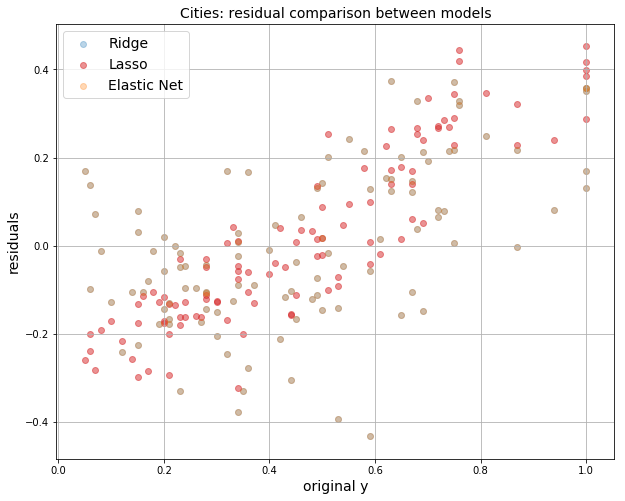

In [108]:
plt.figure(figsize=[10,8])
plt.title("Cities: residual comparison between models",size=14)
plt.scatter(y_city_test, y_city_test - rfe_rcv.predict(x_city_test),label="Ridge",alpha=0.3,color="tab:blue")
plt.scatter(y_city_test, y_city_test - rfe_lcv.predict(x_city_test),label="Lasso",alpha=0.5,color="tab:red")
plt.scatter(y_city_test, y_city_test - rfe_rcv.predict(x_city_test),label="Elastic Net",alpha=0.3,color="tab:orange")
plt.grid()
plt.legend(fontsize=14)
plt.xlabel("original y",size=14)
plt.ylabel("residuals",size=14)

Observing this graph we can see similar phenomena: the lasso regression residuals increase with y, while the ridge and elastic net overlaps, more centered around the  

# 5. ElasticNet penalty surface

* visualize the surface of the $ objective(\alpha, \beta) $ parameters corresponding to the L1 and L2 regularizations. Select the best possible combination of the hyper-parameters that minimize the objective (clue: `from scipy.optimize import minimize`)
    * this task is similar to what you've seen during class, just not for MSE vs. single penalty parameter but MSE vs. two penalty parameters $\alpha, \beta$

* interpret the findings! do you think linear models are powerful enough on this dataset?